In [1]:
!pip install beautifulsoup4 lxml
!apt-get install -y xfoil  # Install XFOIL for airfoil analysis





The following NEW packages will be installed:
  xfoil
0 upgraded, 1 newly installed, 0 to remove and 87 not upgraded.
Need to get 1,922 kB of archives.
After this operation, 4,466 kB of additional disk space will be used.
Ign:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 xfoil amd64 6.99.dfsg+1-3
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 xfoil amd64 6.99.dfsg+1-3 [1,922 kB]
Fetched 1,922 kB in 1min 12s (26.6 kB/s)
Selecting previously unselected package xfoil.
(Reading database ... 129184 files and directories currently installed.)
Preparing to unpack .../xfoil_6.99.dfsg+1-3_amd64.deb ...
Unpacking xfoil (6.99.dfsg+1-3) ...
Setting up xfoil (6.99.dfsg+1-3) ...


In [2]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import requests
import zipfile
import os
import urllib.request as urllib2
from bs4 import BeautifulSoup
import re

In [ ]:
!mkdir -p /kaggle/working/data
!cp /kaggle/input/airfoil/data/*.npy /kaggle/working/data
!ls /kaggle/working/data


xs_test.npy   y_max.npy  ys_test.npy	     ys_train.npy
xs_train.npy  y_min.npy  ys_test_scaled.npy  ys_train_scaled.npy


In [4]:
import numpy as np

xs_train = np.load('data/xs_train.npy')
ys_train = np.load('data/ys_train.npy')
xs_test  = np.load('data/xs_test.npy')
ys_test  = np.load('data/ys_test.npy')

print(xs_train.shape, ys_train.shape)
print(xs_test.shape, ys_test.shape)


(38802, 192, 2) (38802, 2)
(9701, 192, 2) (9701, 2)


In [5]:
import os
import numpy as np

data_path = "data"
npy_files = [f for f in os.listdir(data_path) if f.endswith('.npy')]

# Display structure of the numpy arrays
# for npy_file in npy_files:
#     file_path = os.path.join(data_path, npy_file)
#     data = np.load(file_path)

#     # Assuming the naming convention includes 'train' or 'test' in the filename
#     dataset_type = 'Training' if 'train' in npy_file else 'Testing'

#     print(f"\n{npy_file} ({dataset_type} Dataset):")
#     print(f"Shape: {data.shape}")
#     print(f"Data Type: {data.dtype}")
#     print(f"Sample Data (First 2 Rows):\n{data[:2]}")


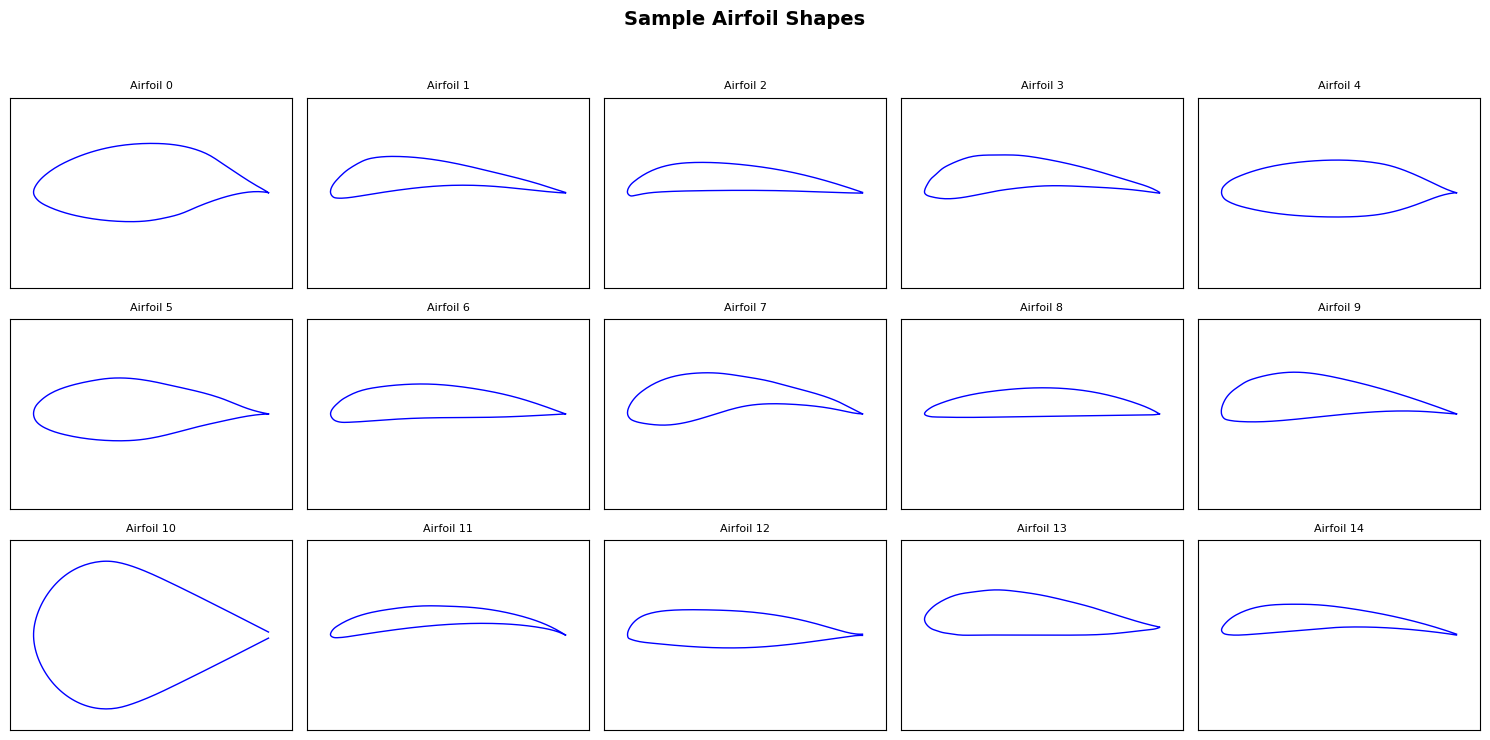

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot airfoils in a grid layout
def plot_airfoils_grid(xs_data, num_samples=15, rows=3, cols=5, title="Sample Airfoil Shapes"):
    num_samples = min(num_samples, len(xs_data))  # Ensure we don't exceed available airfoils
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 2.5))  # Adjust size dynamically
    fig.suptitle(title, fontsize=14, fontweight='bold')

    for i, ax in enumerate(axes.flat):  # Loop over subplots
        if i < num_samples:
            x_coords = xs_data[i, :, 0]  # Extract X coordinates
            y_coords = xs_data[i, :, 1]  # Extract Y coordinates
            ax.plot(x_coords, y_coords, color='blue', linewidth=1)
            ax.set_title(f"Airfoil {i}", fontsize=8)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlim(-0.1, 1.1)  # Normalize X range
            ax.set_ylim(-0.25, 0.25)  # Normalize Y range
        else:
            ax.axis('off')  # Hide extra subplots if not needed

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()

# Run the function with 15 airfoil samples
plot_airfoils_grid(xs_train, num_samples=15, rows=3, cols=5)


In [7]:
!pip install aerosandbox


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 90.2 MB/s eta 0:00:00


In [8]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

class AirfoilDatasetV2(Dataset):
    def __init__(self, xs_path, ys_path=None):
        """
        xs_path: path to xs_train.npy (shape: (N, 192, 2))
        ys_path: path to ys_train.npy (shape: (N, 2)) [CL, CD] or [CD, CL]
                 If you have no aerodynamic data, you can omit it or pass None.
        """
        self.xs = np.load(xs_path)  # shape (N, 192, 2)
        if ys_path is not None:
            self.ys = np.load(ys_path)  # shape (N, 2)
        else:
            self.ys = None

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        coords = self.xs[idx]
        coords = coords.T.astype(np.float32)
        train_coords_y = coords[1]

        # If we have aerodynamic data (CL, CD), extract them
        if self.ys is not None:
            cl = self.ys[idx, 0]
            cd = self.ys[idx, 1]
        else:
            cl = 0.0
            cd = 0.0

        return {
            'train_coords': torch.tensor(coords, dtype=torch.float32),
            'train_coords_y': torch.tensor(train_coords_y, dtype=torch.float32),
            'CD': torch.tensor(cd, dtype=torch.float32),
            'CL': torch.tensor(cl, dtype=torch.float32)
        }

xs_train_path = "data/xs_train.npy"
ys_train_path = "data/ys_train.npy"

dataset = AirfoilDatasetV2(xs_train_path, ys_train_path)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

for i, data in enumerate(dataloader):
    print(f"Batch {i}")
    print(f"Train Coordinates shape: {data['train_coords'].shape}")  
    print(f"Train Coords Y shape:   {data['train_coords_y'].shape}")
    print(f"CD shape: {data['CD'].shape}") 
    print(f"CL shape: {data['CL'].shape}")  
    break


Batch 0
Train Coordinates shape: torch.Size([64, 2, 192])
Train Coords Y shape:   torch.Size([64, 192])
CD shape: torch.Size([64])
CL shape: torch.Size([64])


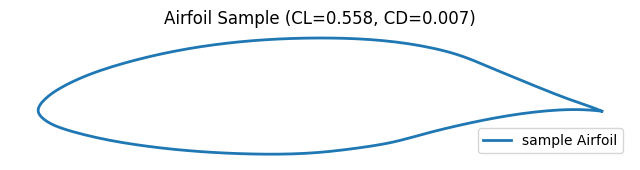

In [9]:
# ---------------------------
# 1. Plot a sample airfoil
# ---------------------------
# Get one sample (for example, the first airfoil)
sample = dataset[0]
coords = sample['train_coords'].numpy()  # shape: (2, 192)
# Transpose for plotting (so each row is a point: (192, 2))
coords_plot = coords.T  
cl_sample = sample['CL'].item()
cd_sample = sample['CD'].item()

plt.figure(figsize=(8,4))
plt.plot(coords_plot[:,0], coords_plot[:,1], label='sample Airfoil', lw=2)
plt.title(f"Airfoil Sample (CL={cl_sample:.3f}, CD={cd_sample:.3f})")
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

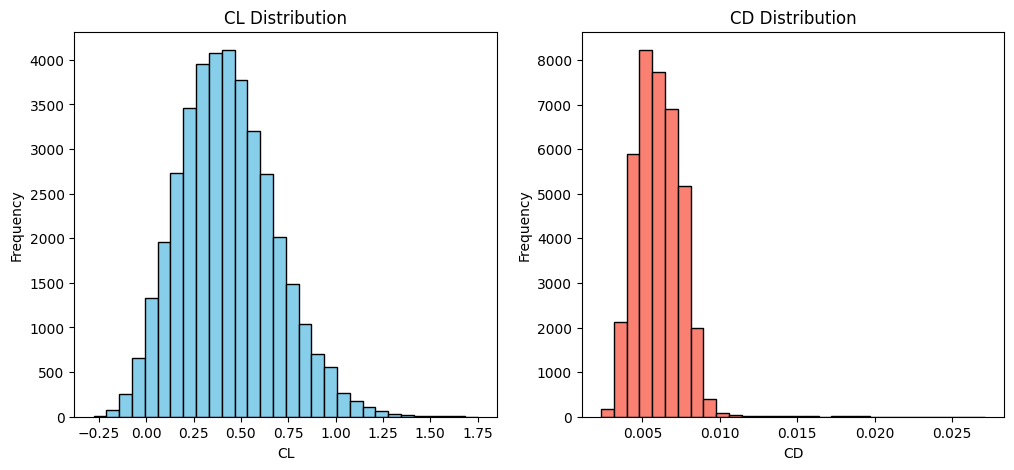

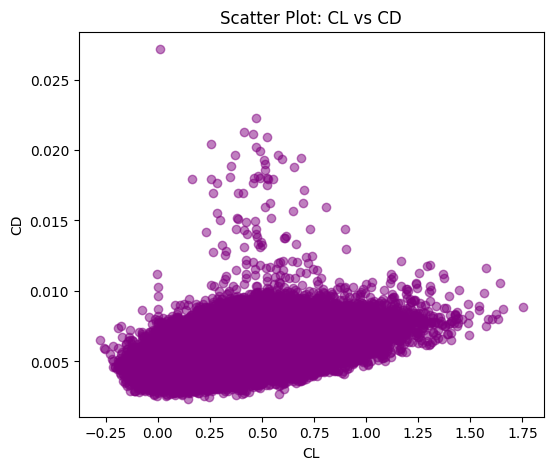

Aerodynamic Coefficient Statistics:
CL: mean = 0.429, std = 0.252, min = -0.278, max = 1.752
CD: mean = 0.006, std = 0.001, min = 0.002, max = 0.027


In [10]:
# ---------------------------
# 2. Visualize Aerodynamic Coefficient Statistics
# ---------------------------
# Load the aerodynamic data directly from the npy file for statistics.
# (Assuming ys_train.npy contains shape (N, 2) with columns [CL, CD])
ys_train = np.load(ys_train_path)
CL_all = ys_train[:, 0]
CD_all = ys_train[:, 1]

# Histograms of CL and CD
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(CL_all, bins=30, color='skyblue', edgecolor='k')
ax[0].set_title('CL Distribution')
ax[0].set_xlabel('CL')
ax[0].set_ylabel('Frequency')
ax[1].hist(CD_all, bins=30, color='salmon', edgecolor='k')
ax[1].set_title('CD Distribution')
ax[1].set_xlabel('CD')
ax[1].set_ylabel('Frequency')
plt.show()

# Scatter plot of CL vs. CD
plt.figure(figsize=(6,5))
plt.scatter(CL_all, CD_all, alpha=0.5, color='purple')
plt.xlabel('CL')
plt.ylabel('CD')
plt.title('Scatter Plot: CL vs CD')
plt.show()

# Print basic statistics
print("Aerodynamic Coefficient Statistics:")
print(f"CL: mean = {np.mean(CL_all):.3f}, std = {np.std(CL_all):.3f}, min = {np.min(CL_all):.3f}, max = {np.max(CL_all):.3f}")
print(f"CD: mean = {np.mean(CD_all):.3f}, std = {np.std(CD_all):.3f}, min = {np.min(CD_all):.3f}, max = {np.max(CD_all):.3f}")

In [11]:
!pip install aerosandbox wandb accelerate ema-pytorch tqdm torch torchvision numpy matplotlib einops


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

In [12]:
!pip install denoising-diffusion-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 3.2 MB/s eta 0:00:00


In [13]:
!mkdir -p /kaggle/working/model_weights/Simple_DDPM

In [14]:
import os
import math
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum, Tensor
from torch.nn import Module, ModuleList
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

from accelerate import Accelerator
from ema_pytorch import EMA

from tqdm.auto import tqdm

from denoising_diffusion_pytorch.version import __version__

# constants

ModelPrediction =  namedtuple('ModelPrediction', ['pred_noise', 'pred_x_start'])

model_save_dir = "working/model_weights/Simple_DDPM"
os.makedirs(model_save_dir, exist_ok=True)

# helpers functions

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to_fn(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# data

class Dataset1D(Dataset):
    def __init__(self, tensor: Tensor):
        super().__init__()
        self.tensor = tensor.clone()

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, idx):
        return self.tensor[idx].clone()

# small helper modules

class Residual(Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
'''
def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv1d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Conv1d(dim, default(dim_out, dim), 4, 2, 1)
'''

def Downsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Conv1d(dim, default(dim_out, dim), 4, stride=2, padding=1)
    )

def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.ConvTranspose1d(dim, default(dim_out, dim), 4, stride=2, padding=1, output_padding=1)
    )



class RMSNorm(Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.g * (x.shape[1] ** 0.5)

class PreNorm(Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = RMSNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# sinusoidal positional embeds

class SinusoidalPosEmb(Module):
    def __init__(self, dim, theta = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class RandomOrLearnedSinusoidalPosEmb(Module):
    """ following @crowsonkb 's lead with random (learned optional) sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim, is_random = False):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim), requires_grad = not is_random)

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

# building block modules

class Block(Module):
    def __init__(self, dim, dim_out, dropout = 0.):
        super().__init__()
        self.proj = nn.Conv1d(dim, dim_out, 3, padding = 1)
        self.norm = RMSNorm(dim_out)
        self.act = nn.SiLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return self.dropout(x)

class ResnetBlock(Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, dropout = 0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, dropout = dropout)
        self.block2 = Block(dim_out, dim_out)
        self.res_conv = nn.Conv1d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

class LinearAttention(Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv1d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv1d(hidden_dim, dim, 1),
            RMSNorm(dim)
        )

    def forward(self, x):
        b, c, n = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) n -> b h c n', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c n -> b (h c) n', h = self.heads)
        return self.to_out(out)

class Attention(Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv1d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv1d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, n = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) n -> b h c n', h = self.heads), qkv)

        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b (h d) n')
        return self.to_out(out)

# model

class Unet1D(Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        dropout = 0.,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16,
        sinusoidal_pos_emb_theta = 10000,
        attn_dim_head = 32,
        attn_heads = 4
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels
        input_channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv1d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        # time embeddings

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim, theta = sinusoidal_pos_emb_theta)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        resnet_block = partial(ResnetBlock, time_emb_dim = time_dim, dropout = dropout)

        # layers

        self.downs = ModuleList([])
        self.ups = ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(ModuleList([
                resnet_block(dim_in, dim_in),
                resnet_block(dim_in, dim_in),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv1d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = resnet_block(mid_dim, mid_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim, dim_head = attn_dim_head, heads = attn_heads)))
        self.mid_block2 = resnet_block(mid_dim, mid_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(ModuleList([
                resnet_block(dim_out + dim_in, dim_out),
                resnet_block(dim_out + dim_in, dim_out),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv1d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = resnet_block(init_dim * 2, init_dim)
        self.final_conv = nn.Conv1d(init_dim, self.out_dim, 1)


    def forward(self, x, time):
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x_skip = h.pop()
            if x.shape[-1] != x_skip.shape[-1]:
                # Adjust the size by trimming or padding
                if x.shape[-1] > x_skip.shape[-1]:
                    x = x[..., :x_skip.shape[-1]]
                else:
                    x_skip = x_skip[..., :x.shape[-1]]

            x = torch.cat((x, x_skip), dim=1)
            x = block1(x, t)

            x_skip = h.pop()
            if x.shape[-1] != x_skip.shape[-1]:
                if x.shape[-1] > x_skip.shape[-1]:
                    x = x[..., :x_skip.shape[-1]]
                else:
                    x_skip = x_skip[..., :x.shape[-1]]

            x = torch.cat((x, x_skip), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

class Unet1DConditional(Module):
    def __init__(
        self,
        dim,
        cond_dim = 1,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        dropout = 0.,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16,
        sinusoidal_pos_emb_theta = 10000,
        attn_dim_head = 32,
        attn_heads = 4
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels
        input_channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv1d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        # time embeddings

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim, theta = sinusoidal_pos_emb_theta)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        resnet_block = partial(ResnetBlock, time_emb_dim = time_dim, dropout = dropout)

        # layers

        self.downs = ModuleList([])
        self.ups = ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(ModuleList([
                resnet_block(dim_in, dim_in),
                resnet_block(dim_in, dim_in),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv1d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = resnet_block(mid_dim, mid_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim, dim_head = attn_dim_head, heads = attn_heads)))
        self.mid_block2 = resnet_block(mid_dim, mid_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(ModuleList([
                resnet_block(dim_out + dim_in, dim_out),
                resnet_block(dim_out + dim_in, dim_out),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv1d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = resnet_block(init_dim * 2, init_dim)
        self.final_conv = nn.Conv1d(init_dim, self.out_dim, 1)

        # conditioning layers
        self.cond_1 = nn.Linear(cond_dim, init_dim)
        self.cond_2 = nn.Linear(init_dim, init_dim*2)
        self.cond_emb = nn.Bilinear(init_dim*2, time_dim, time_dim)


    def forward(self, x, time, conditioning):
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        if conditioning is not None:
            cond = self.cond_1(conditioning)
            cond = F.relu(cond)
            cond = self.cond_2(cond)
            cond = self.cond_emb(cond, t)
            t = t + cond

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x_skip = h.pop()
            if x.shape[-1] != x_skip.shape[-1]:
                # Adjust the size by trimming or padding
                if x.shape[-1] > x_skip.shape[-1]:
                    x = x[..., :x_skip.shape[-1]]
                else:
                    x_skip = x_skip[..., :x.shape[-1]]

            x = torch.cat((x, x_skip), dim=1)
            x = block1(x, t)

            x_skip = h.pop()
            if x.shape[-1] != x_skip.shape[-1]:
                if x.shape[-1] > x_skip.shape[-1]:
                    x = x[..., :x_skip.shape[-1]]
                else:
                    x_skip = x_skip[..., :x.shape[-1]]

            x = torch.cat((x, x_skip), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)



def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)



class GaussianDiffusion1D(Module):
    def __init__(
        self,
        model,
        *,
        seq_length,
        timesteps = 1000,
        sampling_timesteps = None,
        objective = 'pred_noise',
        beta_schedule = 'cosine',
        ddim_sampling_eta = 0.,
        auto_normalize = True
    ):
        super().__init__()
        self.model = model
        self.channels = self.model.channels

        self.seq_length = seq_length

        self.objective = objective

        assert objective in {'pred_noise', 'pred_x0', 'pred_v'}, 'objective must be either pred_noise (predict noise) or pred_x0 (predict image start) or pred_v (predict v [v-parameterization as defined in appendix D of progressive distillation paper, used in imagen-video successfully])'

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        # sampling related parameters

        self.sampling_timesteps = default(sampling_timesteps, timesteps) # default num sampling timesteps to number of timesteps at training

        assert self.sampling_timesteps <= timesteps
        self.is_ddim_sampling = self.sampling_timesteps < timesteps
        self.ddim_sampling_eta = ddim_sampling_eta

        # helper function to register buffer from float64 to float32

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

        # calculate loss weight

        snr = alphas_cumprod / (1 - alphas_cumprod)

        if objective == 'pred_noise':
            loss_weight = torch.ones_like(snr)
        elif objective == 'pred_x0':
            loss_weight = snr
        elif objective == 'pred_v':
            loss_weight = snr / (snr + 1)

        register_buffer('loss_weight', loss_weight)

        # whether to autonormalize

        self.normalize = normalize_to_neg_one_to_one if auto_normalize else identity
        self.unnormalize = unnormalize_to_zero_to_one if auto_normalize else identity

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

    def predict_v(self, x_start, t, noise):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * noise -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * x_start
        )

    def predict_start_from_v(self, x_t, t, v):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape) * v
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def model_predictions(self, x, t, conditioning = None,  clip_x_start = False, rederive_pred_noise = False):
        model_output = self.model(x, t)
        maybe_clip = partial(torch.clamp, min = -1., max = 1.) if clip_x_start else identity

        if self.objective == 'pred_noise':
            pred_noise = model_output
            x_start = self.predict_start_from_noise(x, t, pred_noise)
            x_start = maybe_clip(x_start)

            if clip_x_start and rederive_pred_noise:
                pred_noise = self.predict_noise_from_start(x, t, x_start)

        elif self.objective == 'pred_x0':
            x_start = model_output
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        elif self.objective == 'pred_v':
            v = model_output
            x_start = self.predict_start_from_v(x, t, v)
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        return ModelPrediction(pred_noise, x_start)

    def p_mean_variance(self, x, t, conditioning = None, clip_denoised = True):
        preds = self.model_predictions(x, t, conditioning)
        x_start = preds.pred_x_start

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
        return model_mean, posterior_variance, posterior_log_variance, x_start

    @torch.no_grad()
    def p_sample(self, x, t: int, conditioning = None, clip_denoised = True):
        b, *_, device = *x.shape, x.device
        batched_times = torch.full((b,), t, device = x.device, dtype = torch.long)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, conditioning=conditioning, clip_denoised = clip_denoised)
        noise = torch.randn_like(x) if t > 0 else 0. # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start

    @torch.no_grad()
    def p_sample_loop(self, shape, conditioning = None):
        batch, device = shape[0], self.betas.device

        img = torch.randn(shape, device=device)

        x_start = None

        for t in reversed(range(0, self.num_timesteps)):
            img, x_start = self.p_sample(img, t, conditioning)

        img = self.unnormalize(img)
        return img

    @torch.no_grad()
    def ddim_sample(self, shape, clip_denoised = True):
        batch, device, total_timesteps, sampling_timesteps, eta, objective = shape[0], self.betas.device, self.num_timesteps, self.sampling_timesteps, self.ddim_sampling_eta, self.objective

        times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

        img = torch.randn(shape, device = device)

        x_start = None

        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            time_cond = torch.full((batch,), time, device=device, dtype=torch.long)
            pred_noise, x_start, *_ = self.model_predictions(img, time_cond, clip_x_start = clip_denoised)

            if time_next < 0:
                img = x_start
                continue

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(img)

            img = x_start * alpha_next.sqrt() + \
                  c * pred_noise + \
                  sigma * noise

        img = self.unnormalize(img)
        return img

    @torch.no_grad()
    def sample(self, batch_size = 16, conditioning = None):
        seq_length, channels = self.seq_length, self.channels
        sample_fn = self.p_sample_loop if not self.is_ddim_sampling else self.ddim_sample
        return sample_fn((batch_size, channels, seq_length), conditioning)

    @torch.no_grad()
    def interpolate(self, x1, x2, t = None, lam = 0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)

        assert x1.shape == x2.shape

        t_batched = torch.full((b,), t, device = device)
        xt1, xt2 = map(lambda x: self.q_sample(x, t = t_batched), (x1, x2))

        img = (1 - lam) * xt1 + lam * xt2

        x_start = None

        for i in tqdm(reversed(range(0, t)), desc = 'interpolation sample time step', total = t):
            img, x_start = self.p_sample(img, i)

        return img

    @autocast(enabled = False)
    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def p_losses(self, x_start, t, noise = None):
        b, c, n = x_start.shape
        noise = default(noise, lambda: torch.randn_like(x_start))

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        # if doing self-conditioning, 50% of the time, predict x_start from current set of times
        # and condition with unet with that
        # this technique will slow down training by 25%, but seems to lower FID significantly


        # predict and take gradient step

        model_out = self.model(x, t)

        if self.objective == 'pred_noise':
            target = noise
        elif self.objective == 'pred_x0':
            target = x_start
        elif self.objective == 'pred_v':
            v = self.predict_v(x_start, t, noise)
            target = v
        else:
            raise ValueError(f'unknown objective {self.objective}')

        loss = F.mse_loss(model_out, target, reduction = 'none')
        loss = reduce(loss, 'b ... -> b', 'mean')

        loss = loss * extract(self.loss_weight, t, loss.shape)
        return loss.mean()

    def forward(self, img, *args, **kwargs):
        b, c, n, device, seq_length, = *img.shape, img.device, self.seq_length
        assert n == seq_length, f'seq length must be {seq_length}'
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        img = self.normalize(img)
        return self.p_losses(img, t, *args, **kwargs)



if __name__ == "__main__":
    # Initialize model with sample dimensions
    model = Unet1DConditional(
        dim=32,            # Example dimension, adjust as needed
        cond_dim=4,       # Example conditioning dimension, adjust as needed
        init_dim=None,      # Example initial dimension, adjust as needed
        out_dim=None,         # Example output dimension, adjust as needed
        dim_mults=(1, 2, 4, 8),  # Dimension multipliers
        channels=2,        # Number of input channels, adjust as needed
        dropout=0.       # Example dropout rate, adjust as needed
    )

    # Count the number of parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Number of parameters in Unet1DConditional: {num_params}")


Number of parameters in Unet1DConditional: 5070114


/tmp/ipykernel_18/65918445.py:843: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


In [ ]:
import torch

# Define model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Unet1D(
    dim=32,
    dim_mults=(2, 4,8, 16),
    channels=2,  # X and Y coordinates
    dropout=0.1
).to(device)

# Check number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in Unet1D: {num_params}")

Number of parameters in Unet1D: 4863106


In [16]:
class ResidualBlock1D(nn.Module):
    """
    A 1D residual block with optional downsampling.
    The first conv can do stride=2 if downsample=True, the second conv uses stride=1.
    We'll use kernel=5, pad=2 so that stride=1 doesn't reduce length at all.
    """
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        self.downsample = downsample

        # If we want to downsample, we set stride=2 for the first conv and the shortcut
        stride_first = 2 if downsample else 1
        kernel_size = 5
        pad = 2

        # 1) First conv
        self.bn1 = nn.BatchNorm1d(in_channels, momentum=0.9)
        self.conv1 = nn.Conv1d(in_channels, out_channels,
                               kernel_size=kernel_size,
                               stride=stride_first,
                               padding=pad)
        # 2) Second conv always stride=1
        self.bn2 = nn.BatchNorm1d(out_channels, momentum=0.9)
        self.conv2 = nn.Conv1d(out_channels, out_channels,
                               kernel_size=kernel_size,
                               stride=1,
                               padding=pad)

        # Shortcut (for downsample or channel mismatch)
        if downsample or (in_channels != out_channels):
            self.shortcut_conv = nn.Conv1d(in_channels, out_channels,
                                           kernel_size=1,
                                           stride=stride_first,
                                           padding=0)
        else:
            self.shortcut_conv = nn.Identity()

        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x, debug=False):
        if debug:
            print(f"  [ResidualBlock] Input shape: {x.shape}")
        identity = self.shortcut_conv(x)     # Possibly stride=2 if downsample is True

        # First conv
        out = self.bn1(x)
        out = self.lrelu(out)
        out = self.conv1(out)
        if debug:
            print(f"    After conv1 shape: {out.shape}")

        # Second conv
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)
        if debug:
            print(f"    After conv2 shape: {out.shape}")

        # Add skip
        out = out + identity
        if debug:
            print(f"  [ResidualBlock] Output shape: {out.shape}\n")

        return out

class SurrogateModel1D(nn.Module):
    """
    A 1D ResNet-like approach for (batch, 2, n_points).
    We'll do four "groups" of blocks, each of which can downsample the length dimension in the first block.
    """
    def __init__(self, n_points=192, in_channels=2, depth=16, residual_list=[2,2,2,2]):
        super().__init__()
        self.depth = depth
        self.residual_list = residual_list

        # -- Initial Conv: kernel=5, pad=2, stride=1 => length stays 192
        self.conv_initial = nn.Conv1d(in_channels, depth, kernel_size=5, stride=1, padding=2)
        self.bn_initial = nn.BatchNorm1d(depth, momentum=0.9)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

        # Group0: no downsample in first block
        self.blocks0 = nn.ModuleList([
            ResidualBlock1D(depth, depth, downsample=False)
            for _ in range(residual_list[0])
        ])
        # Group1: first block downsample => depth-> depth*2
        self.resblock1_0 = ResidualBlock1D(depth, depth*2, downsample=True)
        self.blocks1 = nn.ModuleList([
            ResidualBlock1D(depth*2, depth*2, downsample=False)
            for _ in range(residual_list[1]-1)
        ])
        # Group2
        self.resblock2_0 = ResidualBlock1D(depth*2, depth*4, downsample=True)
        self.blocks2 = nn.ModuleList([
            ResidualBlock1D(depth*4, depth*4, downsample=False)
            for _ in range(residual_list[2]-1)
        ])
        # Group3
        self.resblock3_0 = ResidualBlock1D(depth*4, depth*8, downsample=True)
        self.blocks3 = nn.ModuleList([
            ResidualBlock1D(depth*8, depth*8, downsample=False)
            for _ in range(residual_list[3]-1)
        ])

        # Final BN + global avg pool + FC(128) + BN + LReLU + FC(2) + Sigmoid
        self.bn_final = nn.BatchNorm1d(depth*8, momentum=0.9)
        self.fc1 = nn.Linear(depth*8, 128)
        self.bn_fc1 = nn.BatchNorm1d(128, momentum=0.9)
        self.fc2 = nn.Linear(128, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, debug=False):
        if debug:
            print(f"Input shape: {x.shape}")
        out = self.conv_initial(x)
        out = self.bn_initial(out)
        out = self.lrelu(out)
        if debug:
            print(f"After initial conv shape: {out.shape}")

        # group0
        for block in self.blocks0:
            out = block(out, debug=debug)
        if debug:
            print(f"After group0 shape: {out.shape}")

        # group1
        out = self.resblock1_0(out, debug=debug)
        for block in self.blocks1:
            out = block(out, debug=debug)
        if debug:
            print(f"After group1 shape: {out.shape}")

        # group2
        out = self.resblock2_0(out, debug=debug)
        for block in self.blocks2:
            out = block(out, debug=debug)
        if debug:
            print(f"After group2 shape: {out.shape}")

        # group3
        out = self.resblock3_0(out, debug=debug)
        for block in self.blocks3:
            out = block(out, debug=debug)
        if debug:
            print(f"After group3 shape: {out.shape}")

        out = self.bn_final(out)
        out = self.lrelu(out)
        if debug:
            print(f"After bn_final + lrelu shape: {out.shape}")

        # global avg pool => (batch, depth*8, 1)
        out = F.adaptive_avg_pool1d(out, 1)
        if debug:
            print(f"After global avg pool shape: {out.shape}")
        out = out.view(out.size(0), -1)  # => (batch, depth*8)

        out = self.fc1(out)
        out = self.bn_fc1(out)
        out = self.lrelu(out)
        if debug:
            print(f"After fc1 shape: {out.shape}")

        out = self.fc2(out)
        out = self.sigmoid(out)
        if debug:
            print(f"Output shape: {out.shape}")

        return out

surrogate_model = SurrogateModel1D(n_points=192, in_channels=2, depth=16, residual_list=[2,2,2,2])
load_path = rf"/kaggle/input/best_surrogate_model/pytorch/default/1/best_surrogate_model.pt"
surrogate_model.load_state_dict(torch.load(load_path))
surrogate_model.eval()

SurrogateModel1D(
  (conv_initial): Conv1d(2, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn_initial): BatchNorm1d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (blocks0): ModuleList(
    (0-1): 2 x ResidualBlock1D(
      (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (conv1): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (conv2): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (shortcut_conv): Identity()
      (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (resblock1_0): ResidualBlock1D(
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (conv1): Conv1d(16, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.9, affine=T

In [17]:
# ===================
#     DPP losses
# ===================
def calculate_dpp_loss_single_objective(surrogate_model , generated_samples ,lambda_quality=0.5 , EPS =1e-6):
    """
        the loss funciton for calculating the diversity loss (dpp loss)
        inputs:
            -   surrogate_model : must be the instance  of residuaV0 with  correct  weigths
            -   generated_samples : scaled samples generated by diffusion model,must be flatten thhrough dim = 1 (batch ,  192 * 2)
            -   random_quality_weigths = simple torch.tensor weigth ditributed in gaussian. (N , 1)
        outputs : 
            -   single scalar the dpp loss (1,)

        ****** ATTENTION **********
        no need  for rescaling during this procedure
        ***************************
    """
    gen_shape =  generated_samples.shape
    labels = surrogate_model(generated_samples) # (batch , 2)
    generated_samples = generated_samples.reshape(gen_shape[0], -1)
    cl_scaled ,cd_scaled = torch.chunk(labels ,chunks=2, dim =1)
    # define the quality
    quality = cl_scaled/(EPS +  cd_scaled)

    # Compute the similarity matrix
    x_2 = torch.sum(generated_samples ** 2 , dim=1  ,keepdim=True)
    difference_matrix = x_2 - 2 * (generated_samples @ generated_samples.t()) + x_2.t()
    samilarity_matrix = torch.exp(-(1/2) * (difference_matrix)) #gaussian kernel matrix

    # Compute the quality matrix
    quality = quality @ quality.T

    # Compute the dpp value
    if lambda_quality == 0 :
        dpp_L = samilarity_matrix
    else:
        dpp_L = samilarity_matrix * torch.pow(quality , lambda_quality)
    
    # calculating the eigen_values
    eig_vals = torch.linalg.eigh(dpp_L)[0]  # the  real value of the eigens
    loss = - torch.mean(torch.log(torch.clamp(eig_vals , min=EPS , max=1e2)))

    return loss , quality, samilarity_matrix , dpp_L

def calculate_dpp_loss_multi_objective(surrogate_model , generated_samples , random_quality_weigths =[0.5,0.5] ,lambda_quality=0.5 , EPS =1e-6):
    """
        the loss funciton for calculating the diversity loss (dpp loss)
        inputs:
            -   surrogate_model : must be the instance  of residuaV0 with  correct  weigths
            -   generated_samples : scaled samples generated by diffusion model,must be flatten thhrough dim = 1 (batch ,  192 * 2)
            -   random_quality_weigths = simple torch.tensor weigth ditributed in gaussian. (N , 1)
        outputs : 
            -   single scalar the dpp loss (1,)

        ****** ATTENTION **********
        no need  for rescaling during this procedure
        ***************************

        here we want to use multi objective loss according to the definition,
        we want high CL ,low CD
        so we need  to use the Cl,-CD in stacking phase
        also the random_quality_weigths must be -> [Cl_weigths , Cd_weigths] such that the Cl_weight + Cd_weight = 1 (normalized value)
    """
    random_quality_weigths = torch.tensor(random_quality_weigths, device=generated_samples.device).float()
    gen_shape =  generated_samples.shape

    labels = surrogate_model(generated_samples) # (batch , 2)
    generated_samples = generated_samples.reshape(gen_shape[0], -1)
    cl_scaled ,cd_scaled = torch.chunk(labels ,chunks=2, dim =1)
    # define the quality
    y = torch.stack([cl_scaled, -cd_scaled], dim=1)
    quality = (random_quality_weigths * y).sum(dim =1)

    # Compute the similarity matrix
    x_2 = torch.sum(generated_samples ** 2 , dim=1  ,keepdim=True)
    difference_matrix = x_2 - 2 * (generated_samples @ generated_samples.t()) + x_2.t()
    samilarity_matrix = torch.exp(-(1/2) * (difference_matrix)) #gaussian kernel matrix

    # Compute the quality matrix
    quality = quality @ quality.T

    # Compute the dpp value
    if lambda_quality == 0 :
        dpp_L = samilarity_matrix
    else:
        dpp_L = samilarity_matrix * torch.pow(quality , lambda_quality)
    
    # calculating the eigen_values
    eig_vals = torch.linalg.eigh(dpp_L)[0]  # the  real value of the eigens
    loss = - torch.mean(torch.log(torch.clamp(eig_vals , min=EPS , max=1e2)))

    return loss , quality, samilarity_matrix , dpp_L
# ===================
#     DPP losses
# ===================
def calculate_dpp_loss_single_objective(surrogate_model , generated_samples ,lambda_quality=0.5 , EPS =1e-6):
    """
        the loss funciton for calculating the diversity loss (dpp loss)
        inputs:
            -   surrogate_model : must be the instance  of residuaV0 with  correct  weigths
            -   generated_samples : scaled samples generated by diffusion model,must be flatten thhrough dim = 1 (batch ,  192 * 2)
            -   random_quality_weigths = simple torch.tensor weigth ditributed in gaussian. (N , 1)
        outputs : 
            -   single scalar the dpp loss (1,)

        ****** ATTENTION **********
        no need  for rescaling during this procedure
        ***************************
    """
    gen_shape =  generated_samples.shape
    labels = surrogate_model(generated_samples) # (batch , 2)
    generated_samples = generated_samples.reshape(gen_shape[0], -1)
    cl_scaled ,cd_scaled = torch.chunk(labels ,chunks=2, dim =1)
    # define the quality
    quality = cl_scaled/(EPS +  cd_scaled)

    # Compute the similarity matrix
    x_2 = torch.sum(generated_samples ** 2 , dim=1  ,keepdim=True)
    difference_matrix = x_2 - 2 * (generated_samples @ generated_samples.t()) + x_2.t()
    samilarity_matrix = torch.exp(-(1/2) * (difference_matrix)) #gaussian kernel matrix

    # Compute the quality matrix
    quality = quality @ quality.T

    # Compute the dpp value
    if lambda_quality == 0 :
        dpp_L = samilarity_matrix
    else:
        dpp_L = samilarity_matrix * torch.pow(quality , lambda_quality)
    
    # calculating the eigen_values
    eig_vals = torch.linalg.eigh(dpp_L)[0]  # the  real value of the eigens
    loss = - torch.mean(torch.log(torch.clamp(eig_vals , min=EPS , max=1e2)))

    return loss , quality, samilarity_matrix , dpp_L

def calculate_dpp_loss_multi_objective(surrogate_model , generated_samples , random_quality_weigths =[0.5,0.5] ,lambda_quality=0.5 , EPS =1e-6):
    """
        the loss funciton for calculating the diversity loss (dpp loss)
        inputs:
            -   surrogate_model : must be the instance  of residuaV0 with  correct  weigths
            -   generated_samples : scaled samples generated by diffusion model,must be flatten thhrough dim = 1 (batch ,  192 * 2)
            -   random_quality_weigths = simple torch.tensor weigth ditributed in gaussian. (N , 1)
        outputs : 
            -   single scalar the dpp loss (1,)

        ****** ATTENTION **********
        no need  for rescaling during this procedure
        ***************************

        here we want to use multi objective loss according to the definition,
        we want high CL ,low CD
        so we need  to use the Cl,-CD in stacking phase
        also the random_quality_weigths must be -> [Cl_weigths , Cd_weigths] such that the Cl_weight + Cd_weight = 1 (normalized value)
    """
    random_quality_weigths = torch.tensor(random_quality_weigths, device=generated_samples.device).float()
    gen_shape =  generated_samples.shape

    labels = surrogate_model(generated_samples) # (batch , 2)
    generated_samples = generated_samples.reshape(gen_shape[0], -1)
    cl_scaled ,cd_scaled = torch.chunk(labels ,chunks=2, dim =1)
    # define the quality
    y = torch.stack([cl_scaled, -cd_scaled], dim=1)
    quality = (random_quality_weigths * y).sum(dim =1)

    # Compute the similarity matrix
    x_2 = torch.sum(generated_samples ** 2 , dim=1  ,keepdim=True)
    difference_matrix = x_2 - 2 * (generated_samples @ generated_samples.t()) + x_2.t()
    samilarity_matrix = torch.exp(-(1/2) * (difference_matrix)) #gaussian kernel matrix

    # Compute the quality matrix
    quality = quality @ quality.T

    # Compute the dpp value
    if lambda_quality == 0 :
        dpp_L = samilarity_matrix
    else:
        dpp_L = samilarity_matrix * torch.pow(quality , lambda_quality)
    
    # calculating the eigen_values
    eig_vals = torch.linalg.eigh(dpp_L)[0]  # the  real value of the eigens
    loss = - torch.mean(torch.log(torch.clamp(eig_vals , min=EPS , max=1e2)))

    return loss , quality, samilarity_matrix , dpp_L


In [18]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import joblib

class AirfoilDataset_CL_CD(Dataset):
    """
    A PyTorch Dataset that loads pre-processed airfoil coordinates and scaled aerodynamic labels.
    It assumes:
      - xs_path is a .npy file with shape (N, 192, 2) for airfoil coordinates.
      - ys_path is a .npy file with shape (N, 2) containing (CL, CD) values.

    The dataset:
      - Computes global min and max across train+test (precomputed externally and saved)
        for labels so that they are min–max scaled.
      - Returns each sample with airfoil coordinates transposed to shape (2, n_points),
        and the scaled labels.
      - Provides an inverse_scale_label() method and a plot_sample() method.
    """
    def __init__(self, xs_path, ys_path ,label_scaler_path):
        """
        Args:
          xs_path (str): Path to npy file (shape: (N, 192, 2)) with airfoil coordinates.
          ys_path (str): Path to npy file (shape: (N, 2)) with scaled labels (CL, CL/CD).
          y_min_path (str): Path to npy file containing the min values for labels (shape: (1,2)).
          y_max_path (str): Path to npy file containing the max values for labels (shape: (1,2)).
        """
        self.xs = np.load(xs_path)  # (N, 192, 2)
        self.ys = np.load(ys_path)  # (N, 2), already transformed and scaled
        self.label_scaler = None

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        # Load coordinates: shape (192,2)
        coords = self.xs[idx]
        # Transpose to get shape (2, 192): row 0 is x, row 1 is y
        coords = coords.T.astype(np.float32)
        coords_tensor = torch.from_numpy(coords)

        # Get labels (scaled) from the pre-processed file
        cl = self.ys[idx, 0]
        cd = self.ys[idx, 1]
        label_tensor = torch.tensor([cl, cd], dtype=torch.float32)

        # return {
        #     'airfoil_2d_coords': coords_tensor,  # shape (2, 192)
        #     'CL': label_tensor[0],
        #     'CL_CD_ratio': label_tensor[1]
        # }
        return torch.tensor(coords_tensor.reshape(2 ,-1), dtype=torch.float32), label_tensor

    def inverse_scale_label(self, scaled_label):
        """
        Given a label in scaled space (values in [0,1]), invert the min–max scaling.

        Args:
          scaled_label: A NumPy array or tensor of shape (2,) or (batch, 2).

        Returns:
          The denormalized label (CL, CL/CD) as a NumPy array.
        """
        eps = 1e-12
        if isinstance(scaled_label, torch.Tensor):
            scaled_label = scaled_label.cpu().numpy()
        if scaled_label.ndim == 1:
            scaled_label = scaled_label[None, :]
        real_label = self.label_scaler.inverse_transform(scaled_label)
        return real_label

    def plot_sample(self, idx=None):
        """
        Visualize an airfoil sample.
        - If idx is not provided, a random index is chosen.
        - Plots the airfoil shape (x vs. y) and displays the scaled and real (inverted) label values.
        """
        if idx is None:
            idx = np.random.randint(len(self))
        sample = self.__getitem__(idx)
        # coords_tensor = sample['airfoil_2d_coords']  # shape: (2, n_points)
        # cl_scaled = sample['CL'].item()
        # ratio_scaled = sample['CL_CD_ratio'].item()

        coords_tensor = sample[0]  # shape: (2, n_points)
        cl_scaled = sample[1][0]
        ratio_scaled = sample[1][1]

        # Get inverse-scaled (real) labels
        scaled_label = np.array([cl_scaled, ratio_scaled])
        real_label = self.inverse_scale_label(scaled_label)  # shape: (1, 2)
        real_label = real_label.flatten()  # Now [CL_real, (CL/CD)_real]
        cl_real = real_label[0]
        # Compute CD from the ratio: CD = CL / (CL/CD)
        cd_real = cl_real / (real_label[1] + 1e-12)

        # Plot the airfoil: coords_tensor shape (2, n_points)
        x_coords = coords_tensor[0].numpy()
        y_coords = coords_tensor[1].numpy()

        plt.figure(figsize=(6,4))
        plt.plot(x_coords, y_coords, 'b-', linewidth=2)
        plt.title(f"Airfoil {idx}\nScaled: CL={cl_scaled:.3f}, Ratio={ratio_scaled:.3f}\n"
                  f"Real: CL={cl_real:.3f}, CD={cd_real:.3f}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from  sklearn.preprocessing import MinMaxScaler
import  random

scaler =MinMaxScaler()
xs_shape = xs_train.shape
scaler.fit(xs_train.reshape(xs_train.shape[0], -1))
xs_train_scaled = scaler.transform(xs_train.reshape(xs_train.shape[0], -1))
xs_test_scaled = scaler.transform(xs_test.reshape(xs_test.shape[0], -1))

xs_train_scaler_path = "/kaggle/working/data/xs_train_scaled.npy"
xs_test_scaler_path = "/kaggle/working/data/xs_test_scaled.npy"

np.save(xs_train_scaler_path, xs_train_scaled.reshape(len(xs_train_scaled), xs_shape[1] ,xs_shape[2] ))
np.save(xs_test_scaler_path, xs_test.reshape(len(xs_test_scaled), xs_shape[1] ,xs_shape[2] ))

# Training Parameters
EPOCHS = 10
BATCH_SIZE = 128
LR = 1e-3
VIS_EPOCHS = 25
NUM_WORKER = 1
LAMBDA_DPP = 0.01
LAMBDA_QUALITY = 0.5
DPP_WEIGTHS = [0.5,0.5]
dpp_epoch_tres = 170
cash_dpp_loss = 0

# Load dataset



dataset = AirfoilDatasetV2(xs_train_path, ys_train_path)
# dataset = AirfoilDataset_CL_CD(xs_train_path, ys_train_path , None)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers= NUM_WORKER , shuffle=True)

# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=10, verbose=True)

loss_fn = nn.L1Loss()
diffusion = GaussianDiffusion1D(model, seq_length=192, objective='pred_noise', timesteps=1000).to(device)
surrogate_model = surrogate_model.to("cuda")
surrogate_model.eval()


writer = SummaryWriter(log_dir="logs")

# For tracking loss
epoch_losses = []

model_save_dir = "working/model_weights/Simple_DDPM"
os.makedirs(model_save_dir, exist_ok=True)

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{EPOCHS}")
    model.train()    
    for batch_idx, airfoil in enumerate(pbar):
        train_coords = airfoil['train_coords'].cuda().float()
        # train_coords = airfoil[0].cuda().float()
        # Sample random timesteps
        t = torch.randint(0, diffusion.num_timesteps, (train_coords.shape[0],), device=train_coords.device).long()
        noise = torch.randn_like(train_coords, device=train_coords.device)

        # Forward through diffusion
        x_t = diffusion.q_sample(train_coords, t, noise=noise)
        predicted_noise = diffusion.model(x_t, t)

        # Compute loss
        loss = loss_fn(noise, predicted_noise)+LAMBDA_DPP * cash_dpp_loss

        # Calculate the samples for the diversity loss
        # if epoch > dpp_epoch_tres:
        #     model.eval()
        #     with torch.no_grad():
        #         generated_samples = diffusion.sample(batch_size=1)  # sample 4 airfoils
        #     print(generated_samples.shape)
        #     dpp_loss = calculate_dpp_loss_multi_objective(surrogate_model=surrogate_model,
        #                                     generated_samples=generated_samples,
        #                                     random_quality_weigths=DPP_WEIGTHS,
        #                                     lambda_quality=LAMBDA_QUALITY,
        #                                     )
        #     loss += LAMBDA_DPP * dpp_loss
        #     model.train()
        
            
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    avg_loss = epoch_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    writer.add_scalar("Loss/train", avg_loss, epoch)

    # Step scheduler
    scheduler.step(avg_loss)

    # Calculating the dpp loss
    if epoch> dpp_epoch_tres:
        model.eval()
        with torch.no_grad():
            samples = diffusion.sample(batch_size=128)  # sample 4 airfoils
        generated_samples = samples
        dpp_loss = calculate_dpp_loss_multi_objective(surrogate_model=surrogate_model,
                                            generated_samples=generated_samples,
                                            random_quality_weigths=DPP_WEIGTHS,
                                            lambda_quality=LAMBDA_QUALITY,
                                            )[0]
        cash_dpp_loss = dpp_loss.item()

    # ---------------------------
    # Visualize samples inline
    # ---------------------------
    if (epoch % VIS_EPOCHS == 0) or (epoch == EPOCHS - 1):
        model.eval()
        with torch.no_grad():
            samples = diffusion.sample(batch_size=4)  # sample 4 airfoils
        # Plot inline
        samples = samples.cpu().numpy()  # shape: (4, 2, 192)
        fig, axs = plt.subplots(1, 4, figsize=(16, 4))
        for j in range(4):
            coords = samples[j]  # shape (2, 192)
            coords_plot = coords.T  # shape (192, 2)
            axs[j].plot(coords_plot[:, 0], coords_plot[:, 1], lw=2)
            axs[j].set_title(f"Sample {j}")
            axs[j].axis('equal')
            axs[j].axis('off')
        plt.suptitle(f"Generated Samples at Epoch {epoch}", fontsize=14)
        plt.show()  # Show inline in Colab

        # Also log figure to TensorBoard
        writer.add_figure("Samples", fig, epoch)
        plt.close(fig)

    # ---------------------------
    # Save model weights
    # ---------------------------
    if (epoch % 25 == 0) or (epoch == EPOCHS - 1):
        save_path = os.path.join(model_save_dir, f"model_epoch_{epoch}.pt")
        torch.save(model.state_dict(), save_path)

writer.close()

# ---------------------------
# Plot the training loss curve
# ---------------------------
plt.figure(figsize=(8,5))
plt.plot(range(EPOCHS), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Diffusion Model Training Loss')
plt.legend()
plt.show()

2025-05-28 22:45:02.112235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748472302.288640      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748472302.344275      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Epoch 0/10:   0%|          | 0/304 [00:00<?, ?it/s]